In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

# ../../Data/Processed data\250 shojja.xlsx
# ../../Data/Processed data\31 shojja.xlsx
# ../../Data/Processed data\ad-din.xlsx
# ../../Data/Processed data\aichi.xlsx
# ../../Data/Processed data\Al manar.xlsx
# ../../Data/Processed data\Anowar khan.xlsx
# ../../Data/Processed data\azgol ali.xlsx
# ../../Data/Processed data\Delta medical.xlsx
# ../../Data/Processed data\dmd central.xlsx
# ../../Data/Processed data\h&h.xlsx
# ../../Data/Processed data\hfrc.xlsx
# ../../Data/Processed data\ibn sina.xlsx
# ../../Data/Processed data\islami bank.xlsx
# ../../Data/Processed data\lstm_dmc.xlsx
# ../../Data/Processed data\Medical college for women.xlsx
# ../../Data/Processed data\Metropoliton medical.xlsx
# ../../Data/Processed data\police hospital.xlsx
# ../../Data/Processed data\popular medical.xlsx
# ../../Data/Processed data\shomorita.xlsx
# ../../Data/Processed data\Square.xlsx
# ../../Data/Processed data\ssmc.xlsx
# ../../Data/Processed data\united hospital.xlsx
# ../../Data/Processed data\universal.xlsx
# ../../Data/Processed data\Uttara adhunik.xlsx

# df = read_excel('../../Data/Processed data/31 shojja.xlsx')
# df = read_excel('../../Data/Processed data/250 shojja.xlsx')
# df = read_excel('../../Data/Processed data/ad-din.xlsx')
# df = read_excel('../../Data/Processed data/aichi.xlsx')
# df = read_excel('../../Data/Processed data/Al manar.xlsx')
# df = read_excel('../../Data/Processed data/Anowar khan.xlsx')
# df = read_excel('../../Data/Processed data/azgol ali.xlsx')
# df = read_excel('../../Data/Processed data/Delta medical.xlsx')
# df = read_excel('../../Data/Processed data/dmd central.xlsx')
# df = read_excel('../../Data/Processed data/h&h.xlsx')
# df = read_excel('../../Data/Processed data/hfrc.xlsx')
# df = read_excel('../../Data/Processed data/ibn sina.xlsx')
# df = read_excel('../../Data/Processed data/islami bank.xlsx')
df = read_excel('../../Data/Processed data/lstm_dmc.xlsx')
# df = read_excel('../../Data/Processed data/Medical college for women.xlsx')
# df = read_excel('../../Data/Processed data/Metropoliton medical.xlsx')
# df = read_excel('../../Data/Processed data/police hospital.xlsx')
# df = read_excel('../../Data/Processed data/popular medical.xlsx')
# df = read_excel('../../Data/Processed data/shomorita.xlsx')
# df = read_excel('../../Data/Processed data/Square.xlsx')
# df = read_excel('../../Data/Processed data/ssmc.xlsx')
# df = read_excel('../../Data/Processed data/united hospital.xlsx')
# df = read_excel('../../Data/Processed data/universal.xlsx')
# df = read_excel('../../Data/Processed data/Uttara adhunik.xlsx')
# df = read_excel('../../Data/Processed data/Sajeda hospital.xlsx')
# df = read_excel('../../Data/Processed data/Dhaka central.xlsx')

In [3]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [4]:
df.shape

(698, 2)

In [5]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 3
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  17  input_size:  14  num_layers:  1


In [6]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(df, window_size)

In [7]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,92.0,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0
1,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0
2,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0
3,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0
4,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0,40.0,35.0,19.0


In [8]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, False)

In [9]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [10]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (545, 14)  y_train.shape:  (545, 3)  X_test.shape:  (137, 14)  y_test.shape:  (137, 3)


In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [13]:
model = LSTMModel(input_size, hidden_size, num_layers)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

Epoch [1/500], Loss: 7.9634
Epoch [2/500], Loss: 0.0445
Epoch [3/500], Loss: 4.3394


e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [4/500], Loss: 5.0007
Epoch [5/500], Loss: 103.3296
Epoch [6/500], Loss: 499.3942
Epoch [7/500], Loss: 947.8179
Epoch [8/500], Loss: 9.3434
Epoch [9/500], Loss: 7.9969
Epoch [10/500], Loss: 0.7404
Epoch [11/500], Loss: 21.7280
Epoch [12/500], Loss: 63.4587
Epoch [13/500], Loss: 6.8888
Epoch [14/500], Loss: 8.4119
Epoch [15/500], Loss: 0.1222
Epoch [16/500], Loss: 554.4362
Epoch [17/500], Loss: 442.8799
Epoch [18/500], Loss: 3.5140
Epoch [19/500], Loss: 10.2778
Epoch [20/500], Loss: 33.0633
Epoch [21/500], Loss: 35.6301
Epoch [22/500], Loss: 9.3313
Epoch [23/500], Loss: 1962.9183
Epoch [24/500], Loss: 0.8283
Epoch [25/500], Loss: 16.0570
Epoch [26/500], Loss: 0.8211
Epoch [27/500], Loss: 101.7904
Epoch [28/500], Loss: 11.4700
Epoch [29/500], Loss: 7.6826
Epoch [30/500], Loss: 5.6533
Epoch [31/500], Loss: 149.1166
Epoch [32/500], Loss: 107.5077
Epoch [33/500], Loss: 29.7162
Epoch [34/500], Loss: 7773.8940
Epoch [35/500], Loss: 8.9465
Epoch [36/500], Loss: 0.1713
Epoch [37/500], Los

In [16]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 409.3607


In [17]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
# y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
# predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

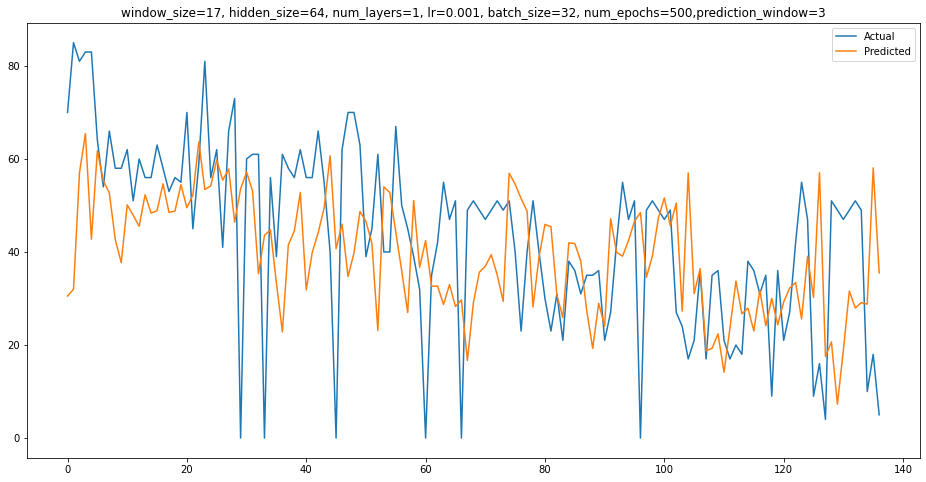

In [18]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [19]:
# MAE, MSE, RMSE losses
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_1, predictions_1)
mse = mean_squared_error(y_test_1, predictions_1)
rmse = np.sqrt(mse)
print("MAE: ", mae, " MSE: ", mse, " RMSE: ", rmse)

MAE:  15.922718284774001  MSE:  404.7382794750243  RMSE:  20.11810824791994


In [20]:
# print errors in 2 decimal places
print("MAE: {:.2f}".format(mae), " MSE: {:.2f}".format(mse), " RMSE: {:.2f}".format(rmse))

MAE: 15.92  MSE: 404.74  RMSE: 20.12
